In [ ]:
!pip install shap

In [ ]:
import pandas as pd
import json
from os.path import join
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import shap
import tensorflow_datasets as tfds


In [ ]:
data, info = tfds.load('movielens/100k-ratings', with_info=True, split='train')

In [ ]:
df = tfds.as_dataframe(data.take(10000), info)
df.head()

,bucketized_user_age,movie_genres,movie_id,movie_title,raw_user_age,timestamp,user_gender,user_id,user_occupation_label,user_occupation_text,user_rating,user_zip_code
0,45.0,[7],b'357',"b""One Flew Over the Cuckoo's Nest (1975)""",46.0,879024327,True,b'138',4,b'doctor',4.0,b'53211'
1,25.0,"[4, 14]",b'709',b'Strictly Ballroom (1992)',32.0,875654590,True,b'92',5,b'entertainment',2.0,b'80525'
2,18.0,[4],b'412',"b'Very Brady Sequel, A (1996)'",24.0,882075110,True,b'301',17,b'student',4.0,b'55439'
3,50.0,"[5, 7]",b'56',b'Pulp Fiction (1994)',50.0,883326919,True,b'60',4,b'healthcare',4.0,b'06472'
4,50.0,"[10, 16]",b'895',b'Scream 2 (1997)',55.0,891409199,True,b'197',18,b'technician',3.0,b'75094'


In [ ]:
# Preprocessing
df = df.drop(columns=['bucketized_user_age', 'movie_id', 'movie_title', 'timestamp', 'user_id', 'user_occupation_label', 'user_zip_code'])
df['user_occupation_text'] = df['user_occupation_text'].str.decode("utf-8")
df['movie_genres'] = df['movie_genres'].apply(lambda x: x[0])
df['user_rating'] = df['user_rating'].astype(int)
gender_mapping = {True: 1, False: 0}
df['user_gender'] = df['user_gender'].apply(lambda x: gender_mapping[x])
df.head()

,movie_genres,raw_user_age,user_gender,user_occupation_text,user_rating
0,7,46.0,1,doctor,4
1,4,32.0,1,entertainment,2
2,4,24.0,1,student,4
3,5,50.0,1,healthcare,4
4,10,55.0,1,technician,3


In [ ]:
# Filter by occupation
top_occupations = ['administrator', 'educator', 'engineer', 'programmer', 'other']
df_new = df.loc[df['user_occupation_text'].isin(top_occupations)]

df_new['user_occupation_text'] = df_new['user_occupation_text'].apply(lambda x: top_occupations.index(x))

df_new.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,movie_genres,raw_user_age,user_gender,user_occupation_text,user_rating
8,4,27.0,1,2,5
9,0,32.0,1,0,2
12,0,44.0,1,4,3
15,0,22.0,1,4,5
17,4,34.0,1,4,3


In [ ]:
# Filter by genre

top_genres = [7, 4, 5, 1]
df_new['movie_genres'].value_counts()
df_new2 = df_new.loc[df['movie_genres'].isin(top_genres)]

# genre_mapping = {7: 'Documentary', 4: "Children's", 5: "Comedy", 1: 'Action'}
df_new2['movie_genres'] = df_new2['movie_genres'].apply(lambda x: top_genres.index(x))
df_new2.head()



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,movie_genres,raw_user_age,user_gender,user_occupation_text,user_rating
8,1,27.0,1,2,5
17,1,34.0,1,4,3
27,1,51.0,0,0,3
29,0,33.0,1,3,4
30,2,37.0,0,0,5


In [ ]:
train_data = df_new2

In [ ]:
feature_cols = ['movie_genres', 'raw_user_age', 'user_gender', 'user_occupation_text']
categorical_cols = ['movie_genres', 'user_gender', 'user_occupation_text', 'user_rating']
numerical_cols = ['raw_user_age']

for cont in numerical_cols:
    train_data[cont] = train_data[cont].astype('float32')

for cat in categorical_cols:
    train_data[cat] = train_data[cat].astype('category')

train_data.dtypes


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


movie_genres            category
raw_user_age             float32
user_gender             category
user_occupation_text    category
user_rating             category
dtype: object

In [ ]:
# Change column names
new_cols = ['movie_genre', 'user_age', 'user_gender', 'user_occupation', 'rating']
train_data.columns = new_cols
train_data.head()

,movie_genre,user_age,user_gender,user_occupation,rating
8,1,27.0,1,2,5
17,1,34.0,1,4,3
27,1,51.0,0,0,3
29,0,33.0,1,3,4
30,2,37.0,0,0,5


In [ ]:
# Separate the data into features and labels
X = train_data.loc[:, new_cols[:-1]]
print(X.shape)

y = train_data.rating
print(y.shape)


(2544, 4)
(2544,)


In [ ]:
# Train a model
model = RandomForestClassifier()
model.fit(X, y)

RandomForestClassifier()

In [ ]:
# Create a shap explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

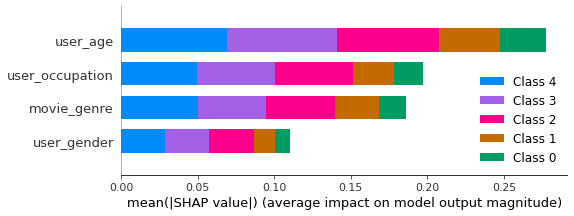

In [ ]:
shap.summary_plot(shap_values, X, plot_type="bar")

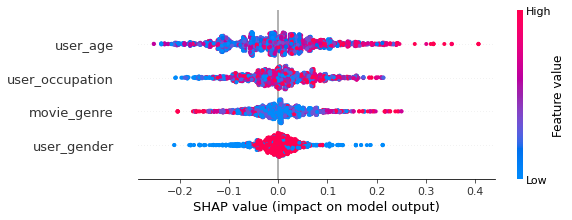

In [ ]:
shap.summary_plot(shap_values[3], X.values, feature_names = X.columns)

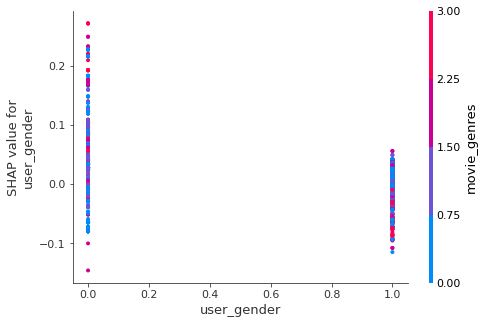

In [ ]:
shap.dependence_plot("user_gender", shap_values[4], X)

In [ ]:
data_row = 0
class_label=0
shap.initjs()
shap.force_plot(explainer.expected_value[4], shap_values[4][i], X.values[i], feature_names = X.columns)

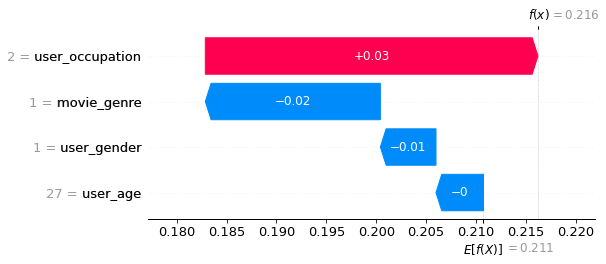

In [ ]:
row = 0
i = 4
shap.waterfall_plot(shap.Explanation(values=shap_values[i][row], 
                                              base_values=explainer.expected_value[i], data=X.iloc[row],  
                                         feature_names=X.columns.tolist()))

In [ ]:
shap_interaction_values = explainer.shap_interaction_values(X)

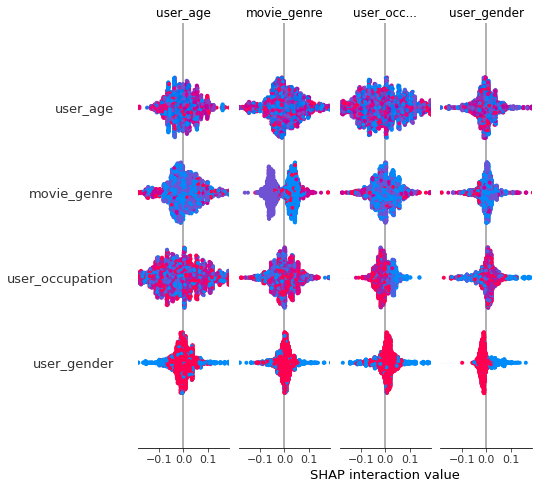

In [ ]:
shap.summary_plot(shap_interaction_values[4], X)
